In [9]:
import shutil
import os

source_path = "/kaggle/input/freelancer-income-vs-skills"
destination_path = "/content/freelancer-income-vs-skills"

shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Copied successfully to:", destination_path)


Copied successfully to: /content/freelancer-income-vs-skills


In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score
)

In [11]:
# Change to your file path later
df = pd.read_csv("/content/freelancer-income-vs-skills/freelancer_earnings - freelancer_earnings_vs_skillstack_dataset.csv")

print("Shape:", df.shape)
display(df.head(3))
display(df.sample(3))
display(df.info())
display(df.describe(include="all").T)

Shape: (500, 11)


,freelancer_id,category,primary_skills,years_experience,experience_level,region,country,education,hourly_rate_usd,annual_income_usd,primary_platform
0,FL0001,AI/ML Engineering,"Computer Vision, TensorFlow, Data Science",1.6,junior,Middle East,Israel,Master,66.41,"$58,873.61",Direct Client
1,FL0002,Backend Development,"PHP, Ruby, Go",8.3,senior,Middle East,UAE,Bootcamp,112.79,"$108,183.05",Freelancer
2,FL0003,UI/UX Design,"Sketch, Wireframing, Adobe XD",3.6,mid,North America,US,Self-taught,94.21,"$88,681.22",Freelancer


,freelancer_id,category,primary_skills,years_experience,experience_level,region,country,education,hourly_rate_usd,annual_income_usd,primary_platform
380,FL0381,Data Engineering,"SQL, Data Warehousing, Python",1.1,junior,Asia Pacific,Philippines,PhD,18.84,"$18,961.33",Freelancer
369,FL0370,Backend Development,"PHP, Ruby, Python",8.3,senior,Western Europe,UK,Self-taught,149.34,"$148,786.51",Freelancer
144,FL0145,Backend Development,"Java, Go, Python",5.5,senior,Western Europe,Switzerland,Bootcamp,196.20,"$197,000.64",LinkedIn


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   freelancer_id      500 non-null    object 
 1   category           500 non-null    object 
 2   primary_skills     500 non-null    object 
 3   years_experience   500 non-null    float64
 4   experience_level   500 non-null    object 
 5   region             500 non-null    object 
 6   country            500 non-null    object 
 7   education          500 non-null    object 
 8   hourly_rate_usd    500 non-null    float64
 9   annual_income_usd  500 non-null    object 
 10  primary_platform   500 non-null    object 
dtypes: float64(2), object(9)
memory usage: 43.1+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
freelancer_id,500,500,FL0500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,500,10,Cybersecurity,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
primary_skills,500,377,"Network Security, Penetration Testing, Cryptog...",6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
years_experience,500.0,NaN,NaN,NaN,5.85,2.934779,0.5,3.6,5.6,7.8,14.0
experience_level,500,3,senior,279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,500,7,Eastern Europe,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,500,22,Israel,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,500,5,Bachelor,187,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_rate_usd,500.0,NaN,NaN,NaN,97.14982,52.697831,17.28,55.1825,84.445,130.4975,281.47
annual_income_usd,500,500,"$136,126.59",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print("Duplicates:", df.duplicated().sum())
print("Total missing cells:", df.isna().sum().sum())

missing = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing.head(20))

mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Memory usage: {mem_mb:.2f} MB")

Duplicates: 0
Total missing cells: 0


,0
freelancer_id,0.0
category,0.0
primary_skills,0.0
years_experience,0.0
experience_level,0.0
region,0.0
country,0.0
education,0.0
hourly_rate_usd,0.0
annual_income_usd,0.0


Memory usage: 0.26 MB


In [13]:
def infer_col_types(df, cat_threshold=25):
    types = {"numeric": [], "categorical": [], "text": [], "datetime": [], "other": []}
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            types["numeric"].append(c)
        elif pd.api.types.is_datetime64_any_dtype(df[c]):
            types["datetime"].append(c)
        elif pd.api.types.is_string_dtype(df[c]) or df[c].dtype == "object":
            nunique = df[c].nunique(dropna=True)
            avg_len = df[c].astype(str).str.len().mean()
            # heuristic: if long strings -> text
            if avg_len > 30 and nunique > cat_threshold:
                types["text"].append(c)
            else:
                types["categorical"].append(c)
        else:
            types["other"].append(c)
    return types

col_types = infer_col_types(df)
col_types

{'numeric': ['years_experience', 'hourly_rate_usd'],
 'categorical': ['freelancer_id',
  'category',
  'primary_skills',
  'experience_level',
  'region',
  'country',
  'education',
  'annual_income_usd',
  'primary_platform'],
 'text': [],
 'datetime': [],
 'other': []}

In [14]:
numeric_cols = col_types["numeric"]

def numeric_summary(df, cols):
    rows = []
    for c in cols:
        s = df[c].dropna()
        rows.append({
            "col": c,
            "count": s.shape[0],
            "mean": s.mean(),
            "std": s.std(),
            "min": s.min(),
            "p1": s.quantile(0.01),
            "p5": s.quantile(0.05),
            "p50": s.quantile(0.50),
            "p95": s.quantile(0.95),
            "p99": s.quantile(0.99),
            "max": s.max(),
            "missing_%": df[c].isna().mean()*100
        })
    return pd.DataFrame(rows).sort_values("missing_%", ascending=False)

display(numeric_summary(df, numeric_cols))

,col,count,mean,std,min,p1,p5,p50,p95,p99,max,missing_%
0,years_experience,500,5.85000,2.934779,0.50,0.7000,1.395,5.600,11.30,12.700,14.00,0.0
1,hourly_rate_usd,500,97.14982,52.697831,17.28,21.1831,32.913,84.445,196.01,238.018,281.47,0.0


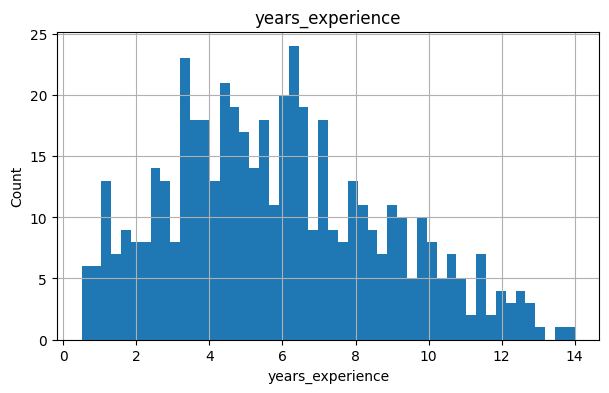

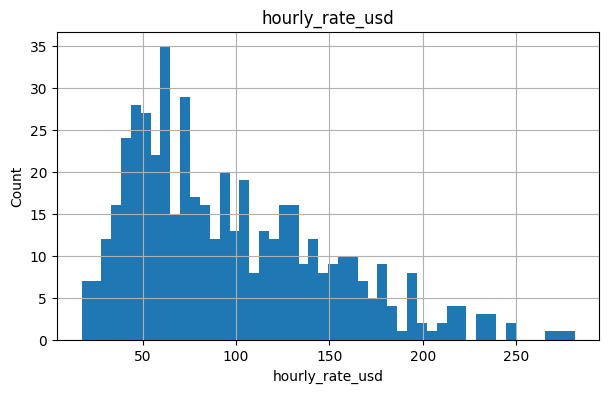

In [15]:
def plot_hist(df, col, bins=50):
    plt.figure(figsize=(7,4))
    df[col].dropna().hist(bins=bins)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

for c in numeric_cols[:6]:
    plot_hist(df, c)

In [16]:
cat_cols = col_types["categorical"]

def top_categories(df, col, top_n=15):
    vc = df[col].value_counts(dropna=False).head(top_n)
    share = (vc / len(df) * 100).round(2)
    return pd.DataFrame({"count": vc, "share_%": share})

for c in cat_cols[:6]:
    print("\n", "="*60, "\n", c)
    display(top_categories(df, c))


 freelancer_id


,count,share_%
freelancer_id,,
FL0500,1,0.2
FL0001,1,0.2
FL0002,1,0.2
FL0003,1,0.2
FL0484,1,0.2
FL0483,1,0.2
FL0482,1,0.2
FL0481,1,0.2
FL0480,1,0.2



 category


,count,share_%
category,,
Cybersecurity,68,13.6
DevOps,58,11.6
Web Development,58,11.6
Full Stack,51,10.2
UI/UX Design,48,9.6
Blockchain,46,9.2
Backend Development,45,9.0
AI/ML Engineering,45,9.0
Data Engineering,45,9.0



 primary_skills


,count,share_%
primary_skills,,
"Network Security, Penetration Testing, Cryptography",6,1.2
"Cryptography, Network Security, Security Audit",6,1.2
"Security Audit, Cryptography, Penetration Testing",6,1.2
"Security Audit, Cryptography, Network Security",5,1.0
"Security Audit, Penetration Testing, Cryptography",5,1.0
"Cryptography, Penetration Testing, Security Audit",5,1.0
"Network Security, Cryptography, Penetration Testing",5,1.0
"Java, Python, C#",4,0.8
"Penetration Testing, Network Security, Security Audit",4,0.8



 experience_level


,count,share_%
experience_level,,
senior,279,55.8
mid,175,35.0
junior,46,9.2



 region


,count,share_%
region,,
Eastern Europe,84,16.8
Middle East,81,16.2
Western Europe,72,14.4
Africa,72,14.4
Latin America,69,13.8
North America,63,12.6
Asia Pacific,59,11.8



 country


,count,share_%
country,,
Israel,42,8.4
UAE,39,7.8
US,39,7.8
South Africa,36,7.2
Nigeria,36,7.2
Ukraine,31,6.2
Romania,28,5.6
Poland,25,5.0
Brazil,24,4.8


In [17]:
def rare_label_rate(df, col, min_count=50):
    vc = df[col].value_counts(dropna=False)
    rare = vc[vc < min_count].sum()
    return rare / len(df)

for c in cat_cols[:10]:
    print(c, "rare_rate:", round(rare_label_rate(df, c), 3))

freelancer_id rare_rate: 1.0
category rare_rate: 0.53
primary_skills rare_rate: 1.0
experience_level rare_rate: 0.092
region rare_rate: 0.0
country rare_rate: 1.0
education rare_rate: 0.124
annual_income_usd rare_rate: 1.0
primary_platform rare_rate: 0.106


In [19]:
# Example: set your skills column name later
skills_col = "primary_skills"

# turn into list of skills
def parse_skills(x):
    if pd.isna(x):
        return []
    x = str(x).strip()
    # basic splitting heuristic
    for sep in ["|", ",", ";"]:
        if sep in x:
            return [t.strip().lower() for t in x.split(sep) if t.strip()]
    return [x.lower()]

df["skills_list"] = df[skills_col].apply(parse_skills)

# Flatten skills
all_skills = pd.Series([s for row in df["skills_list"] for s in row])
top_skills = all_skills.value_counts().head(30)
display(top_skills)

,count
python,68
react,62
cryptography,58
node.js,54
penetration testing,51
security audit,50
network security,45
ethereum,32
smart contracts,32
kubernetes,32


In [20]:
from itertools import combinations
from collections import Counter

pairs = Counter()
for row in df["skills_list"]:
    uniq = sorted(set(row))
    for a,b in combinations(uniq, 2):
        pairs[(a,b)] += 1

top_pairs = pd.DataFrame(pairs.most_common(20), columns=["pair","count"])
display(top_pairs)

,pair,count
0,"(cryptography, penetration testing)",41
1,"(cryptography, security audit)",40
2,"(cryptography, network security)",35
3,"(penetration testing, security audit)",33
4,"(network security, penetration testing)",28
5,"(network security, security audit)",27
6,"(node.js, react)",25
7,"(ethereum, smart contracts)",19
8,"(ethereum, solidity)",17
9,"(ethereum, web3)",17


In [21]:
# skill frequency
skill_freq = all_skills.value_counts()
df["max_skill_freq"] = df["skills_list"].apply(lambda lst: max([skill_freq.get(s, 0) for s in lst], default=0))

threshold = df["max_skill_freq"].quantile(0.80)
df["high_demand_skill"] = (df["max_skill_freq"] >= threshold).astype(int)

df["high_demand_skill"].value_counts(normalize=True)

,proportion
high_demand_skill,
0,0.74
1,0.26


In [22]:
salary_col = "salary"  # change later if exists
if salary_col in df.columns:
    df["high_salary"] = (df[salary_col] >= df[salary_col].quantile(0.75)).astype(int)
    print(df["high_salary"].value_counts(normalize=True))

In [23]:
df["n_skills"] = df["skills_list"].apply(len)
df["unique_skills"] = df["skills_list"].apply(lambda x: len(set(x)))
df["skill_diversity"] = df["unique_skills"] / df["n_skills"].replace(0, 1)

# Top K skill binary flags
TOP_K = 50
top_k_skills = all_skills.value_counts().head(TOP_K).index.tolist()

for s in top_k_skills:
    df[f"skill_{s}"] = df["skills_list"].apply(lambda x: int(s in x))

In [24]:
date_col = "posting_date"
if date_col in df.columns:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["post_month"] = df[date_col].dt.month
    df["post_dow"] = df[date_col].dt.dayofweek

In [25]:
def frequency_encode(df, col):
    freq = df[col].value_counts(dropna=False) / len(df)
    return df[col].map(freq)

for c in cat_cols:
    if df[c].nunique(dropna=True) > 50:
        df[f"{c}_freq"] = frequency_encode(df, c)